# Dataset Exploration for the Redacted Text Detection Dataset

This notebook provides a brief overview of the dataset, as well as some basic instructions and information for the dataset.

## Index 

1. [Dataset Structure](#dataset_structure)
2. [Dataset Samples](#dataset_samples)
3. [Inspecting Annotations](#annotations)
4. [Annotation Statistics](#annotation_statistics)


<a id="dataset_structure"><h2>Dataset Structure</h2></a>

The dataset in this research is contained in the `dataset` folder, and is structured as follows.

```
dataset
│
└───train
│      │   classic_train.json
│      │   extended_train.json
│      └── images
│    
│
└───test
      │   classic_test.json
      │   extended_test.json
      └── images
```

The `.json` files contain the annotations for the images in the standard [COCO Image Annotation Format](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/md-coco-overview.html), where the ground truth masks are encoded in the Run Length Encoding (RLE) format. The`images` folder contains the images for the train and test set, which includes images without annotations. The `json` files determine which ones of the images is selected from the `images` folder.

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.axes_grid1 import ImageGrid

<a id="dataset_samples"><h2>Dataset Samples</h2></a>

Below we will sample some images from the classic dataset, show them to get an idea of the images contained in it, after which we will show how to work with the ground truth data contained withing the dataset.

In [2]:
sample_images = [Image.open(path) for path in random.sample(glob('../resources/dataset/train/images/*.png'), k=5)]

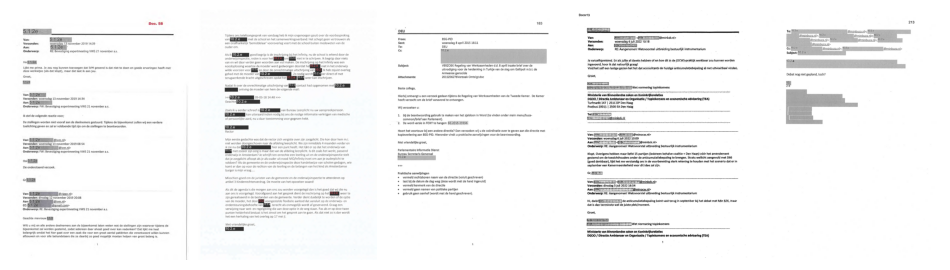

In [3]:
fig = plt.figure(figsize=(12, 4))

grid = ImageGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    # Iterating over the grid returns the Axes.
    ax.set_axis_off()
    ax.imshow(im)

plt.show()

<a id="annotations"><h2>Inspecting the annotations</h2></a>

The images above are a bit too small to properly see the annotations, so we will highlight a single image and load the annotations using the `pycocotools` package and the `COCO` class, which also makes it easy to do visualizations.

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [5]:
# Load each of the json files as a COCO style dataset
classic_train_set = COCO('../resources/dataset/train/classic_train.json')
classic_test_set = COCO('../resources/dataset/test/classic_test.json')

extended_train_set = COCO('../resources/dataset/train/extended_train.json')
extended_test_set =  COCO('../resources/dataset/test/extended_test.json')

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


We can now sample some files with annotations and show them.

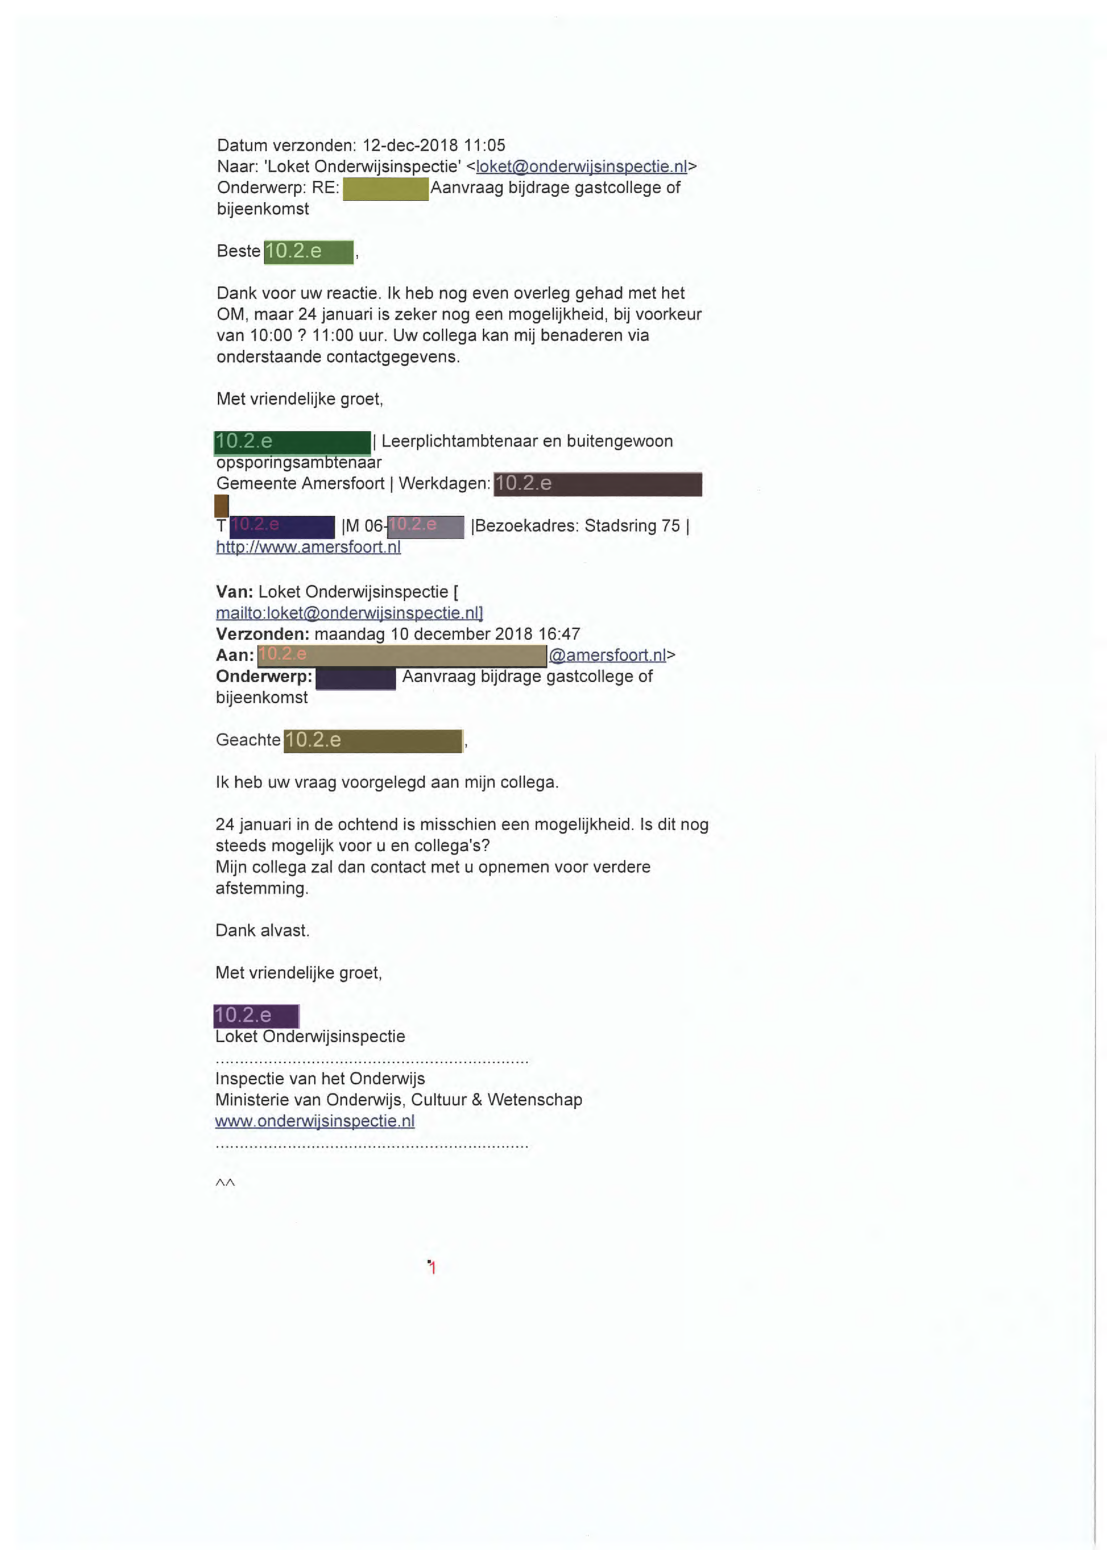

In [6]:
plt.rcParams["figure.figsize"] = (20, 20)
sample_image = classic_train_set.getImgIds()[0]
# we also need to get the image file_name
image_filename = classic_train_set.loadImgs(sample_image)[0]['file_name']
image = Image.open(os.path.join('../resources/dataset/train/images', image_filename))

sample_annotations = classic_train_set.getAnnIds(sample_image)
# Save image and its labeled version.
plt.axis("off")
plt.imshow(np.asarray(image))
classic_train_set.showAnns(classic_train_set.loadAnns(sample_annotations))
plt.show()

Let's also print the number of pages in the dataset, where we also included pages that do not contain annotations.

In [7]:
print("The total number of pages in the dataset is %d" % (len(extended_train_set.getImgIds()) + len(extended_test_set.getImgIds())))

The total number of pages in the dataset is 1464


<a id="annotation_statistics"><h2>Annotation statistics</h2></a>

We have also included the annotation types in the json files for convencience, so we can easily get the number of redactions for each type. We use the `extended_train` and `extended_test` as this contains all the images, also the ones without annotations. We will have to use some code to combine the statistics over the train and test sets and to show the overall statistics.

In [8]:
from pycocotools.mask import area

def get_annotation_type_information(list_of_datasets: list):
    """
    list_of_datasets: List of multiple COCO style datasets that should be combine d
    for the statistics.
    output: a dictionary where each entry is an image and the values are the types of the 
    redactions for all of the segments in that image.
    """
    output_dict = {}
    # loop trough the intput datasets
    for coco_dataset in list_of_datasets:
        # loop over all images
        for image in coco_dataset.loadImgs(coco_dataset.getImgIds()):
            image_filename = image['file_name']
            # load the annotations using the ids retrieved from the COCO object
            image_annotations = coco_dataset.loadAnns(coco_dataset.getAnnIds(image['id']))
            # update the annotations to also include the size
            # since we are using RLE masks ,we we can simply call `area` to get the required info.
            annotation_info = [{'type': annot['type'], 'size': area(annot['segmentation'])} for annot in image_annotations]
            output_dict[image_filename] = annotation_info
    return output_dict
    

Now that we have written the function, we will run the function on both the extended train and test to include all images.

In [9]:
complete_annotation_dict = get_annotation_type_information([extended_train_set, extended_test_set])

Also get the statistics for the the extended test set

In [10]:
extended_test_annotation_dict = get_annotation_type_information([extended_test_set])
extended_test_annotation_types = [annot['type'] for image_annots in extended_test_annotation_dict.values() for annot in image_annots]

Let's now first display the sizes of the test dataset.

In [11]:
pd.DataFrame({'Number of Annotations':  pd.Series(extended_test_annotation_types).value_counts()})

,Number of Annotations
black,1338
border,911
gray,795
color,542


And next we will print the number of annottions of each type for the complete dataset.

In [12]:
complete_dataset_types = [annot['type'] for image_annots in complete_annotation_dict.values() for annot in image_annots]

In [13]:
pd.DataFrame({'Number of Annotations':  pd.Series(complete_dataset_types).value_counts()})

,Number of Annotations
black,3914
gray,3242
border,2535
color,1660


There is a total of 11351 segments in the dataset


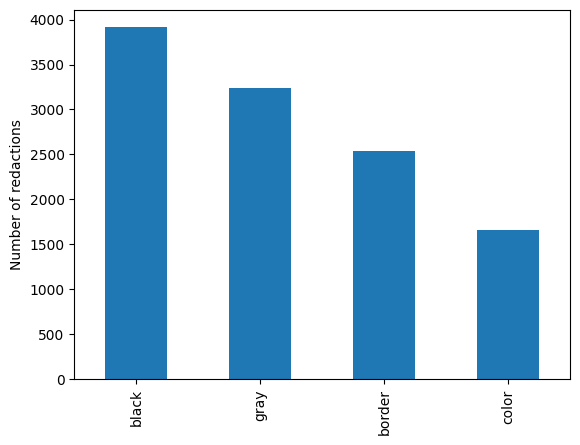

In [14]:
import matplotlib 
# next we combine all the redaction types into one list an plot the distribution
annotation_types = [annot['type'] for image_annots in complete_annotation_dict.values() for annot in image_annots]
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
print("There is a total of %d segments in the dataset" % len(annotation_types))
pd.Series(annotation_types).value_counts().plot(kind='bar')
plt.ylabel("Number of redactions")
plt.show()

Next up we will plot the distribution of the number of segments per image, and then the detailed distributed for the indidvudal redaction types.

In [15]:
segment_distribution = pd.Series([len(annots) for annots in complete_annotation_dict.values()])

The average number of redactions per pages is 7


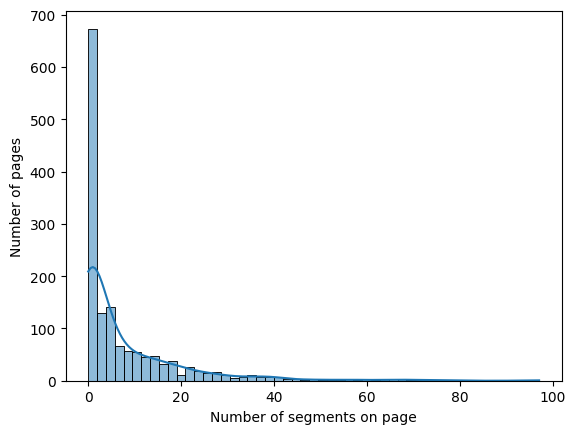

In [16]:
sns.histplot(segment_distribution, kde=True)
plt.xlabel("Number of segments on page")
plt.ylabel("Number of pages")
print("The average number of redactions per pages is %d" % segment_distribution.mean())
plt.show()

Now that we have the overall statistics of the segments, we will also be looking a bit into the specifics for the types of pages.

In [17]:
page_redaction_types = {filename:{'type': complete_annotation_dict[filename][0]['type'] if len(complete_annotation_dict[filename]) else 'no_annotation', 'num_segments': len(complete_annotation_dict[filename])} for filename in complete_annotation_dict.keys()} 

In [18]:
redaction_type_df = pd.DataFrame(page_redaction_types).T

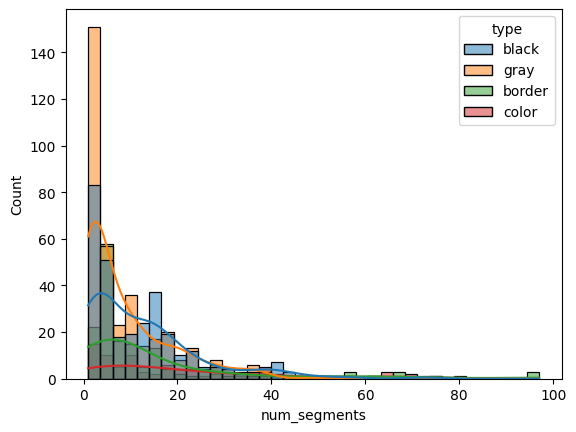

In [19]:
sns.histplot(data=redaction_type_df[redaction_type_df['type']!='no_annotation'], hue='type', x='num_segments',
            kde=True)
plt.show()

## Statistics on the redaction sizes

For the final exploration we take a look at the average sizes of the redactions, and again split this into the different redaction types. This kind of information can also be easily extracted from the coco format, and we have already put it in the `annotation_dict` dictionary.

In [20]:
segment_area_distribution = pd.Series([annot['size'] for key in complete_annotation_dict.keys() for annot in complete_annotation_dict[key]])
segment_type_distribution = pd.Series([annot['type'] for key in complete_annotation_dict.keys() for annot in complete_annotation_dict[key]])

The average size of a redaction in pixels is 30973


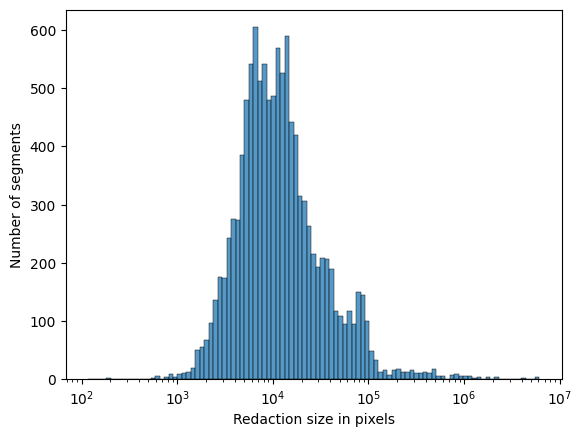

In [21]:
sns.histplot(segment_area_distribution, log_scale=[True, False])
plt.xlabel("Redaction size in pixels")
plt.ylabel("Number of segments")
print("The average size of a redaction in pixels is %d" % segment_area_distribution.mean())
plt.show()

This average translates to roughly 100*300 pixels for a redaction on average.

Now we again plot the the sizes per redaction type.

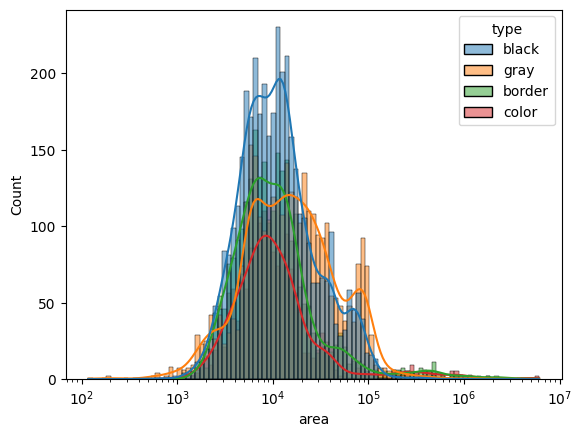

In [22]:
area_df = pd.DataFrame({'area': segment_area_distribution, 'type': segment_type_distribution})
sns.histplot(data=area_df[area_df['type']!='no_annotation'], hue='type', x='area',
            kde=True, log_scale=[True, False])
plt.show()